## ANN - Artificial Neural Networks


The goal is to show how the complexity of the dataset and the design of the ANN (number of neurons and number of layers) with different parameters i.e. like learning rate and activation functions influence the performance of the ANN.<br>


** An artificial dataset, one for regression and one for classification 

In [131]:
pip install nnfs

Note: you may need to restart the kernel to use updated packages.


In [132]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from nnfs.datasets import spiral_data

In [233]:
Nsample = 1000
Nclasses = 5 
[X, Y] = spiral_data(samples = Nsample, classes = Nclasses)


#split dataset into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)



#normalize features between 0 and 1
X_min = X.min(axis=0) 
# Minimum of each feature 
X_max = X.max(axis=0) 
# Maximum of each feature 
X_normalized = (X - X_min) / (X_max - X_min)



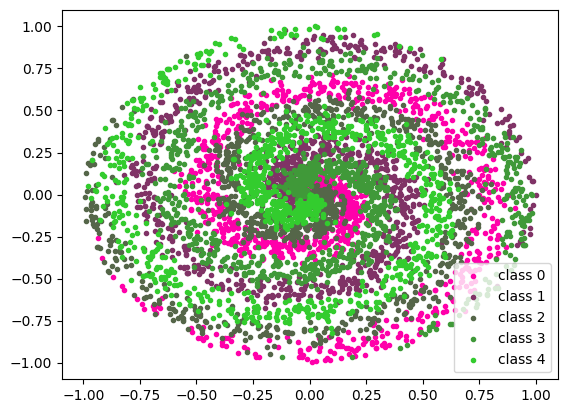

In [234]:
for n in range (Nclasses): 
    idx = np.argwhere(Y==n) [:, 0]
    xplot = X[idx, 0] 
    yplot = X[idx, 1]
    plt.scatter(xplot, yplot, marker = '.', color = [1/(n+1), n/Nclasses, 2/(2*n + 3)], label = 'class ' + str(n))
plt.legend()
plt.show()


## Network Design

In [235]:
Nneurons1     = 64
Nneurons2     = 64
Nsteps        = 20000 #number of iterations aka epochs
learning_rate = 0.2
decay         = 0.001
momentum      = 0.8

Nfeatures     = X.shape[1]
optimizer     = Optimizer_SGD(learning_rate = learning_rate, decay = decay, momentum = momentum)

dense1        = Layer_Dense(Nfeatures, Nneurons1)
dense2 = Layer_Dense(Nneurons1, Nneurons1)
dense1_cla     = Layer_Dense(Nneurons1, Nclasses) #for classification: Nclasses values for each data point
dense1_reg = Layer_Dense(Nneurons1, 1)

dense1 = Layer_Dense(Nfeatures, Nneurons1)
activation1 = Activation_ReLU()
dropout1 = Layer_Dropout(0.2)  # 20% dropout

# Forward pass
dense1.forward(X)
activation1.forward(dense1.output)
dropout1.forward(activation1.output)

dvalues = np.random.rand(*dropout1.output.shape)  # Example gradient for backward pass
dropout1.backward(dvalues)
activation1.backward(dropout1.dinputs)
dense1.backward(activation1.dinputs)

#SECOND LAYER
dense2 = Layer_Dense(Nneurons1, Nneurons2)
activation2 = Activation_ReLU()
dropout2 = Layer_Dropout(0.3)  # 30% dropout after second hidden layer

dense2.forward(dropout1.output)
activation2.forward(dense2.output)
dropout2.forward(activation2.output) 




In [236]:
class Layer_Dropout:
    def __init__(self, rate):
        self.rate = 1 - rate

    def forward(self, inputs):
        self.inputs = inputs
        self.mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        self.output = inputs * self.mask

    def backward(self, dvalues):
        self.dinputs = dvalues * self.mask







        


In [237]:
class Layer_Dense():
    
    def __init__(self, n_inputs, n_neurons):
        self.weights = np.random.randn(n_inputs, n_neurons)
        self.biases  = np.zeros((1, n_neurons))
        
    def forward(self, inputs):
        self.output  = np.dot(inputs, self.weights) + self.biases
        self.inputs  = inputs

    def backward(self, dvalues):
        #gradients
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases  = np.sum(dvalues, axis = 0, keepdims = True)
        self.dinputs  = np.dot(dvalues, self.weights.T)

  
   



In [238]:
class Activation_ReLU():
    
    def forward(self, inputs):
        self.output  = np.maximum(0, inputs)
        self.inputs  = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0#ReLU derivative



In [239]:
class Activation_Sigmoid():
        
    def forward(self, inputs):
        self.output = np.clip(1/(1 + np.exp(-inputs)), 1e-7, 1-1e-7)
        self.inputs = inputs

    def backward(self, dvalues):
        sigm         = self.output
        deriv        = np.multiply(sigm, (1 - sigm))#inner derivative of sigmoid
        self.dinputs = np.multiply(deriv, dvalues)



## Training and Optimization

In [240]:
class Activation_Softmax:
  
    def forward(self,inputs):
        self.inputs = inputs
        exp_values  = np.exp(inputs - np.max(inputs, axis = 1,\
                                      keepdims = True))#max in order to 
                                                       #prevent overflow
        #normalizing probs (Boltzmann dist.)
        probabilities = exp_values/np.sum(exp_values, axis = 1,\
                                      keepdims = True)  
        self.output   = probabilities                                                
    
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        
        for i, (single_output, single_dvalues) in \
            enumerate(zip(self.output, dvalues)):
            
            single_output   = single_output.reshape(-1,1)
            jacobMatr       = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            self.dinputs[i] = np.dot(jacobMatr, single_dvalues)


class Loss:
     
     def calculate(self, output, y):
         
         sample_losses = self.forward(output, y)
         data_loss     = np.mean(sample_losses)
         return(data_loss)
    
    
class Loss_CategoricalCrossEntropy(Loss): 

     def forward(self, y_pred, y_true):
         samples = len(y_pred)
         #removing vals close to zero and one bco log and accuracy
         y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
         
         #now, depending on how classes are coded, we need to get the probs
         if len(y_true.shape) == 1:#classes are encoded as [[1],[2],[2],[4]]
             correct_confidences = y_pred_clipped[range(samples), y_true]
         elif len(y_true.shape) == 2:#classes are encoded as
                                    #[[1,0,0], [0,1,0], [0,1,0]]
             correct_confidences = np.sum(y_pred_clipped*y_true, axis = 1)
         #now: calculating actual losses
         negative_log_likelihoods = -np.log(correct_confidences)
         return(negative_log_likelihoods)
         
     def backward(self, dvalues, y_true):
         Nsamples = len(dvalues)
         Nlabels  = len(dvalues[0])
         #turning labels into one-hot i. e. [[1,0,0], [0,1,0], [0,1,0]], if
         #they are not
         if len(y_true.shape) == 1:
            y_true = np.eye(Nlabels)[y_true]
         #normalized gradient
         self.dinputs = -y_true/dvalues/Nsamples



#Creating a class as parent for softmax, loss and entropy classes. 
#Actually not neccessary, but saves code when building the ANN
class Activation_Softmax_Loss_CategoricalCrossentropy():
    
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss       = Loss_CategoricalCrossEntropy()
        
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output#the probabilities
        #calculates and returns mean loss
        return(self.loss.calculate(self.output, y_true))
        
    def backward(self, dvalues, y_true):
        Nsamples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis = 1)
        self.dinputs = dvalues.copy()
        #calculating normalized gradient
        self.dinputs[range(Nsamples), y_true] -= 1
        self.dinputs = self.dinputs/Nsamples


In [241]:
class Optimizer_SGD:
    #initializing with a default learning rate of 0.01
    def __init__(self, learning_rate = 0.01, decay = 0, momentum = 0):
        self.learning_rate         = learning_rate
        self.current_learning_rate = learning_rate
        self.decay                 = decay
        self.iterations            = 0
        self.momentum              = momentum
        
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1/ (1 + self.decay*self.iterations))
        
    def update_params(self, layer):
        
        #if we use momentum
        if self.momentum:
            
            #check if layer has attribute "momentum"
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums   = np.zeros_like(layer.biases)
                
            #now the momentum parts
            weight_updates = self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            bias_updates = self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
            
        else:
            
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates   = -self.current_learning_rate * layer.dbiases
        
        layer.weights += weight_updates
        layer.biases  += bias_updates
        
    def post_update_params(self):
        self.iterations += 1


In [242]:
Nneurons1     = 64
Nsteps        = 20000 #number of iterations aka epochs
learning_rate = 0.2
decay         = 0.001
momentum      = 0.8

Nfeatures     = X.shape[1]
optimizer     = Optimizer_SGD(learning_rate = learning_rate, decay = decay, momentum = momentum)

dense1        = Layer_Dense(Nfeatures, Nneurons1)
dense2 = Layer_Dense(Nneurons1, Nneurons1)
dense_cla     = Layer_Dense(Nneurons1, Nclasses) #for classification: Nclasses values for each data point
dense_reg = Layer_Dense(Nneurons1, 1)



In [243]:
ReLU            = Activation_ReLU()
Sigm            = Activation_Sigmoid()
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

In [244]:

Target = Y

In [245]:
#Mean Squared Error (MSE) as the loss function

alpha = 0.001

#forward part:
dense1.forward(X)
ReLU.forward(dense1.output)
dense_reg.forward(ReLU.output)

#comparing target to output
Ypred = dense_reg.output
dE    = Ypred - Target #outermost derivative

MSE   = np.sum(abs(dE))/(Nsample*Nclasses)
print('MSE = ' + str(MSE))

#backward part:
dense_reg.backward(dE)
ReLU.backward(dense_reg.dinputs)
dense1.backward(ReLU.dinputs)

#finally, we apply gradient descent
dense_reg.weights -= alpha * dense_reg.dweights 
dense_reg.biases  -= alpha * dense_reg.dbiases

dense1.weights    -= alpha * dense1.dweights 
dense1.biases     -= alpha * dense1.dbiases

MSE = 12489.133338749923


ValueError: shapes (5000,5000) and (1,64) not aligned: 5000 (dim 1) != 1 (dim 0)

In [246]:
Monitor = np.zeros((Nsteps,3)) #for storing loss, learning rate and accuracy

for epoch in range(Nsteps):
    #forward part:
    dense1.forward(X)
    ReLU.forward(dense1.output)
    dense_cla.forward(ReLU.output)
    loss = loss_activation.forward(dense_cla.output, Target)
    
    #comparing target to output
    predictions = np.argmax(loss_activation.output, axis = 1)
    accuracy    = np.mean(predictions == Target)

    
    #backward part:
    loss_activation.backward(loss_activation.output, Target)

    #loss_activation.dinputs = dL, i.e. the derivative of the loss, hence the outermost derivative
    dense_cla.backward(loss_activation.dinputs)
    ReLU.backward(dense_cla.dinputs)
    dense1.backward(ReLU.dinputs)
    
    #finally, we apply gradient descent to all learnables
    optimizer.pre_update_params()#decaying learning rate
    optimizer.update_params(dense1)
    optimizer.update_params(dense_cla)
    optimizer.post_update_params()#just increasing iteration by one
            
    Monitor[epoch,0] = accuracy
    Monitor[epoch,1] = loss
    Monitor[epoch,2] = optimizer.current_learning_rate
            
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'accuracy: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'actual learning rate: {optimizer.current_learning_rate}')

epoch: 0, accuracy: 0.212, loss: 3.274, actual learning rate: 0.2
epoch: 100, accuracy: 0.321, loss: 1.496, actual learning rate: 0.18181818181818182
epoch: 200, accuracy: 0.373, loss: 1.463, actual learning rate: 0.16666666666666669
epoch: 300, accuracy: 0.411, loss: 1.432, actual learning rate: 0.15384615384615385
epoch: 400, accuracy: 0.439, loss: 1.403, actual learning rate: 0.14285714285714288
epoch: 500, accuracy: 0.459, loss: 1.377, actual learning rate: 0.13333333333333333
epoch: 600, accuracy: 0.488, loss: 1.352, actual learning rate: 0.125
epoch: 700, accuracy: 0.504, loss: 1.329, actual learning rate: 0.1176470588235294
epoch: 800, accuracy: 0.519, loss: 1.307, actual learning rate: 0.11111111111111112
epoch: 900, accuracy: 0.529, loss: 1.287, actual learning rate: 0.10526315789473684
epoch: 1000, accuracy: 0.534, loss: 1.268, actual learning rate: 0.1
epoch: 1100, accuracy: 0.545, loss: 1.250, actual learning rate: 0.09523809523809523
epoch: 1200, accuracy: 0.553, loss: 1.2

## Evaluation
 - Monitored the loss and the accuracy for the different epochs. 
  -For classification, generated a confusion chart and plot a histogramm of the different probabilities 
Evaluation of the performance of the ANN with the test set in the same way.<br>
<br>
Experiment with different<br>
- training to test set ratios<br>
- different numbers of features in the data 
- features that correlate
- different numbers of data points (n sample)



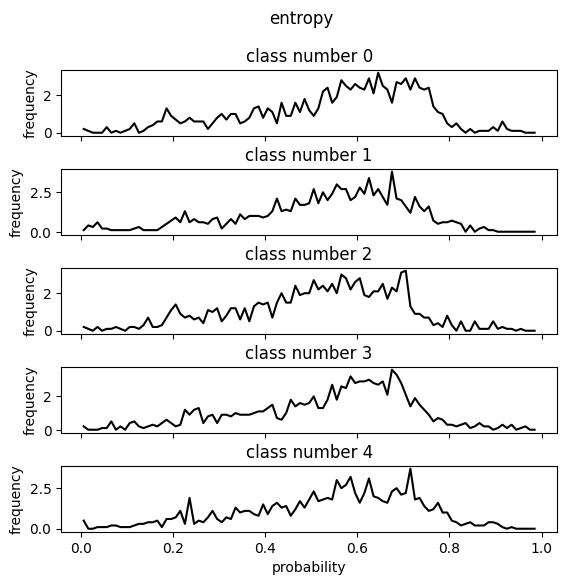

In [247]:
probabilities = loss_activation.output
ClassLabs     = np.arange(Nclasses)

fig2, ax2 = plt.subplots(Nclasses, 1, sharex = True)
fig2.set_figheight(6)
fig2.subplots_adjust(hspace = 0.5)
fig2.suptitle('entropy')
for L in ClassLabs:
    idx = np.argwhere(Target == L)[:,0]
    (value, where) = np.histogram(probabilities[idx,L],\
                                  bins = np.arange(0,1,0.01),\
                                  density = True)
    w = 0.5*(where[1:] + where[:-1])
    ax2[L].plot(w, value, 'k-')

    ax2[L].set_ylabel('frequency')
    ax2[L].set_title('class number ' + str(L))
ax2[Nclasses-1].set_xlabel('probability')

plt.show()

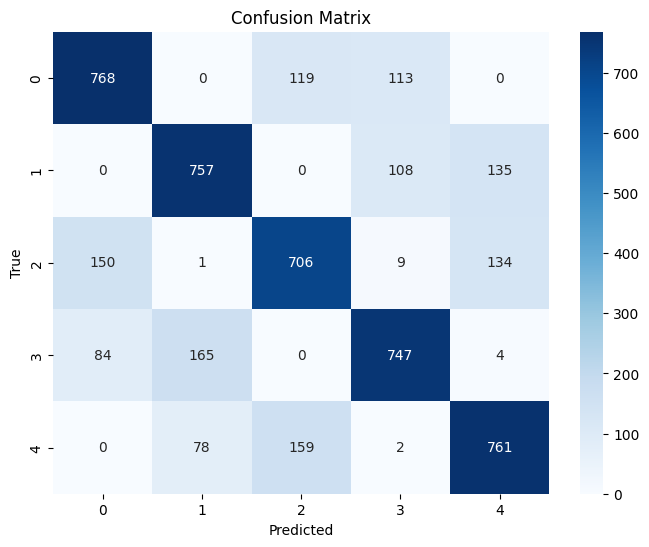

In [248]:
predicted_labels = np.argmax(probabilities, axis = 1)
cm               = confusion_matrix(Target, predicted_labels)

# Step 4: Plot confusion matrix
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues',\
            xticklabels = ClassLabs, yticklabels = ClassLabs)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Explanations of: 
- Architecture choices
- how dropout was implemented.
- training performance (loss and accuracy plots).
- results and key insights.

In building the ANN model, I created a second layer (dense2) that is optimal for complex datasets. Adding such a layer to the hidden layer can also assist increasing accuracy and performance of the model. I then added the activation layers, ReLU and Sigmoid functions to add flexibility concerning activation functions.

To minimize overfitting of the data, I implemented dropout by setting the range from 20% within the first layer to 30% in the second later so that 20-30% of the neurons were dropped in each pass. For example, once the output from layer one is computed, it will then go to ReLU using activation1. After those outputs are computed, the function dropout1.forward(activation1.output), will drop 20% of those neurons at random before passing them onto the second layer. The same process will repeat for the second layer which will remove 30% of those neurons. Neurons are “dropped” by setting them equal to 0. I also applied dropout to the backward pass to ensure that the dropped neurons in the backward pass are not applied in backpropagation.

I use the Softmax function, which is similar to a Boltzmann distribution, to convert the output of the final layer into actual probabilities. This process adds a Softmax layer from the last hidden layer, transforming the output into a probability distribution that represents the model’s confidence in each class. By maximizing entropy, Softmax provides a clear probabilistic interpretation of the network’s predictions, making it suitable for classification tasks.
Once I output the softmax function, I can apply cross-entropy as a loss function for classification. This will guide the model to increase accuracy over time by comparing the prediction values to the actual values. For regression, I used MSE as the loss function since we do not need to include probabilities when assessing regression. MSE will square the average difference between the predicted and actual values.


After running our code and generating a graph with 20,000 iterations, a sample size (Nsample) of 1000, and features normalized between 0 and 1, we achieved an accuracy of 72.3%, a loss of 0.750, and a learning rate of 0.00957. While an accuracy of 72.3% is not necessarily poor, there is room for improvement. Enhancing the model could involve increasing the number of layers, neurons, and sample size to help the model generalize more effectively. Other adjustments, such as tuning dropout rates, learning rate, and decay, could also improve performance.
Through testing variations of features and Nsamples, I observed that multiple factors can impact loss and overall performance. Increasing the number of iterations (epochs) tends to boost accuracy by allowing the model to learn more complex patterns. However, simply increasing the
sample size did not significantly impact accuracy. This suggests we look into other areas such as adding more layers that can help the model accommodate the extra data. Additionally, higher sample sizes reduced noise when comparing entropy distributions for Nsamples = 200 vs. Nsamples = 2000, resulting in a more generalized dataset with fewer peaks and a smoother, more stable distribution.


The confusion matrix of our initial model indicates that Classes 0, 1, and 2 were well-classified, with Class 0 correctly classified 754 times, Class 1 classified 725 times, and Class 2 classified 648 times. However, there were confusions between Class 1 and Class 3, as well as between Classes 2, 4, and 0, suggesting some overlap in the model which could be indicative of overfitting. When I increased the number of features, the confusion between classes decreased, likely due to improved class separation. Conversely, increasing the number of samples led to a increase in confusions between classes, indicating that the model may require adjustments to handle a larger dataset effectively.